# Hello there

I'm just putting together a quick notebook to get you started looking at the data, and doing some quick plotting of the SST anomalies we impose in the climate model (on top of the climatological SSTs) and the corresponding changes in regional precipitation which the climate model generates

In [1]:
import warnings
warnings.filterwarnings('ignore') # filter out deprecation warnings for now

In [2]:
""" 
First, some imports
"""
import numpy as np
import xarray as xr # << get used to xarray, it's awesome
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # << cartopy is what lets us make pretty maps of the world
import math

In [8]:
from utils import point_delta_precip_vector
from scipy.optimize import curve_fit

In [6]:
## Loading in the data
delta_SST = xr.open_dataarray("delta_SST_pr.nc").sel(idx=slice(0, int(5545*0.8)-1)).compute() #only select 80% of data for training
delta_precip = xr.open_dataarray("delta_precip_10deg.nc").sel(idx=slice(0, int(5545*0.8)-1)).compute()
    
# Calculate the GTO and save it in GTO_data folder
delta_precip_vector = point_delta_precip_vector(delta_precip, mylat=mylat, mylon=mylon, time_avg='ANNUAL', weight_by_lat=True)

In [24]:
x = delta_SST.sel(lat=5, lon=180).values # the x values are the delta_SST values
            
# fit functional form to data
popt, pcov = curve_fit(exponential_func, x, delta_precip_vector, p0 = [0.5, 1, -1], maxfev=1000)
a, b, c = popt[0], popt[1], popt[2]

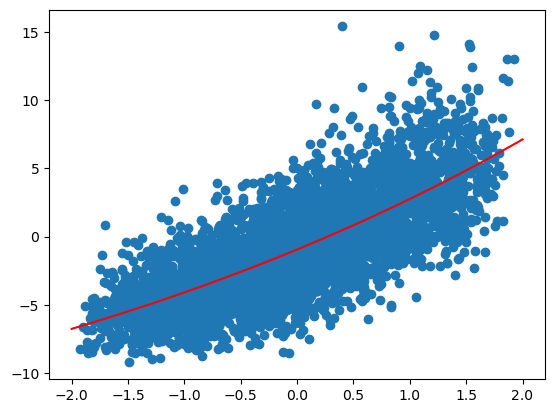

In [29]:
best_fit_line = exponential_func(np.linspace(-2, 2, 100), a, b, c)

fig, ax = plt.subplots()
plt.scatter(x, delta_precip_vector)
plt.plot(np.linspace(-2, 2, 100), best_fit_line, color='red')

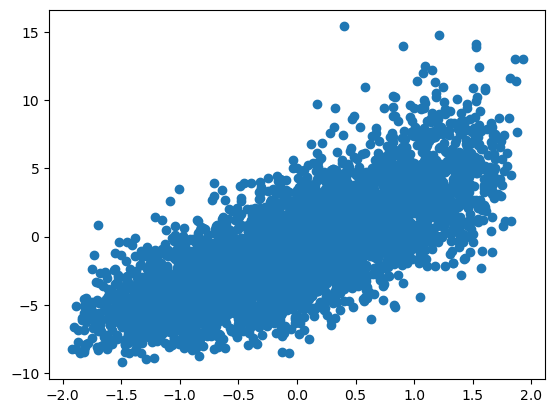

In [22]:
plt.scatter(x, delta_precip_vector)

In [3]:
""" Useful function to quickly make maps """    
    
def map_with_latlon(lw_=2, central_longitude=0):
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

    fig, ax = plt.subplots(dpi=100, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=central_longitude)})

    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines(lw=lw_)
    ax.set_global()
    
    return fig, ax


### Actual SST data

In [4]:
SST_all = xr.open_dataset("control_SSTs.nc")['ice_cov']
SST_all

<xarray.DataArray 'ice_cov' (time: 25, lat: 145, lon: 192)>
[696000 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * time     (time) datetime64[ns] 1998-12-16T12:00:00 ... 2000-12-14T12:00:00
Attributes:
    units:      fraction
    long_name:  BCS Pseudo Sea-ice concentration

In [5]:
""" 
Load in the climatological SSTs

There are 25 months of data
"""
SST_base = xr.open_dataset("control_SSTs.nc")['SST_cpl'] 
SST_base

<xarray.DataArray 'SST_cpl' (time: 25, lat: 145, lon: 192)>
[696000 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * time     (time) datetime64[ns] 1998-12-16T12:00:00 ... 2000-12-14T12:00:00
Attributes:
    units:      deg_C
    long_name:  BCS Pseudo SST

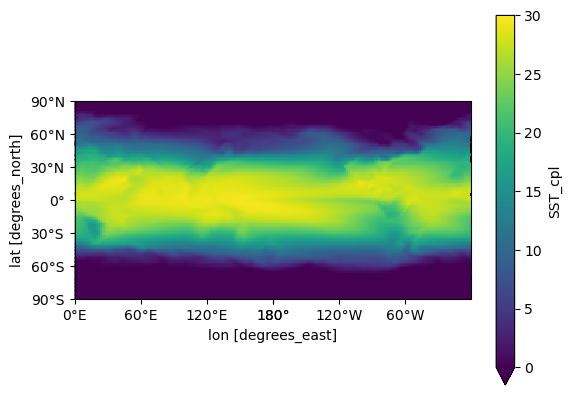

In [7]:
# Plot the time-averaged climatological SSTs

# Note that sea-surface temperature is also defined over land, but the model just ignores these points...

fig, ax = map_with_latlon(central_longitude=180)

SST_base.mean('time').plot(ax=ax, vmin=0, vmax=30,
                           transform=ccrs.PlateCarree()) # <<< this line helps matplotlib understand lat-lon coordinates

# How to mask out the land?

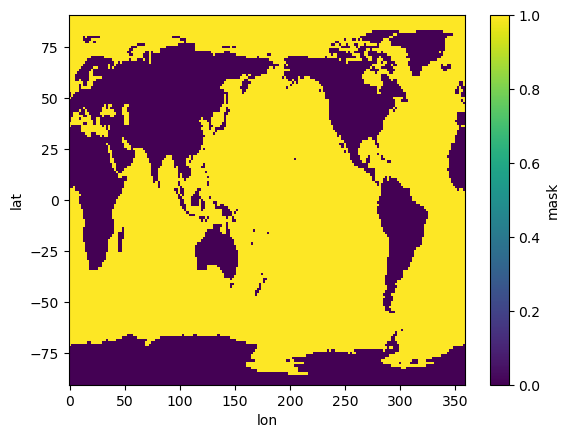

In [6]:
import regionmask
import cartopy.crs as ccrs
landmask = np.isnan(regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(SST_base.lon.values, SST_base.lat.values))
landmask.plot()

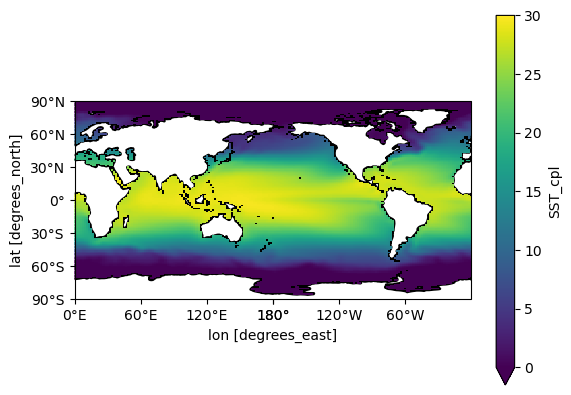

In [9]:
# Redo the same plot as before, but masking out the land points!
# using `.where()`
fig, ax = map_with_latlon(central_longitude=180)

SST_base.mean('time').where(landmask).plot(ax=ax, 
                                           vmin=0, vmax=30, 
                                           transform=ccrs.PlateCarree()) # <<< this line helps matplotlib understand lat-lon coordinates

# Nice! Now you can more clearly see how the distribution of sea-surface temperatures looks like in the control simulation. Most notably, SSTs are warmer near the equator than poleward, and they tend to be warmed in the Western Pacific than the Eastern Pacific.

## We can show this nicely by plotting `SST-SST.mean('lon')`

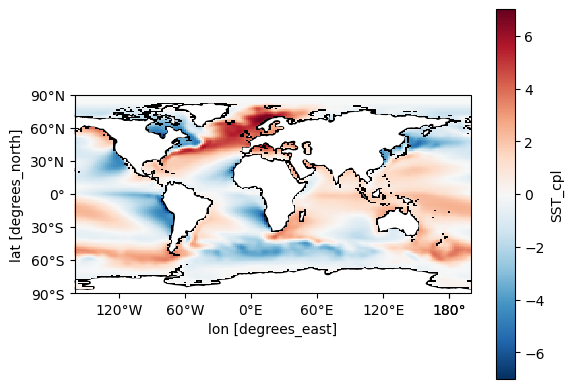

In [10]:
# Redo the same plot as before, but masking out the land points!
# using `.where()`
fig, ax = map_with_latlon(central_longitude=20)

(SST_base.mean('time')-SST_base.mean(['time', 'lon'])).where(landmask).plot(ax=ax, transform=ccrs.PlateCarree())

### The red regions show where the ocean temperatures are warmed than the average for that latitude, and vice-versa for blue  

We can plot a similar graph but considering the temperatures across a given longitude.

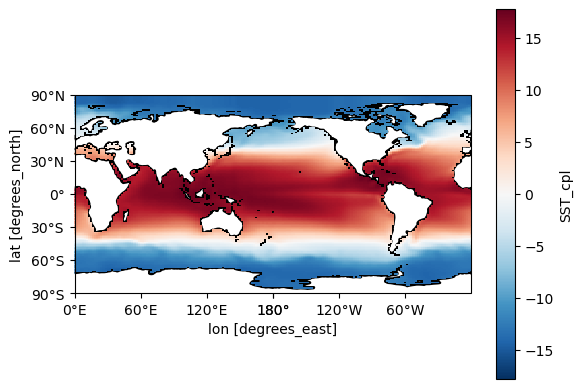

In [11]:
fig, ax = map_with_latlon(central_longitude=180)
(SST_base.mean('time') - SST_base.mean(['time', 'lat'])).where(landmask).plot(
    ax=ax, transform=ccrs.PlateCarree())

# What about precipitation?!

Now, lets check out what the distribution of precipitation roughly looks like in the control climate. 

Note: This is a bit of a subtle point, but in these simulations (done by Baker et al 2019) they do "pairs" of control+perturbed simulations! (Different initial condition each time). This is because the answer you get from a climate model depends *slightly* on the precise initial conditions you use (because of the chaotic nature of the atmosphere and 'Butterfly Effect' etc). So they just alter the initial conditions slightly every time they run the model. 

In [7]:
""" 
Load the control precipitation (i.e., what the model gives when we just use "SST_base", above)
"""
control_precip = xr.open_dataset(f'/gws/nopw/j04/aopp/andreww/CPDN/data/control/item5216_monthly_mean/item5216_monthly_mean_b001_1999-01_2000-12.nc')['item5216_monthly_mean']
control_precip

<xarray.DataArray 'item5216_monthly_mean' (time2: 24, z1: 1, latitude1: 145, longitude1: 192)>
[668160 values with dtype=float32]
Coordinates:
  * time2       (time2) object 1999-01-16 00:00:00 ... 2000-12-16 00:00:00
  * z1          (z1) float32 0.0
  * latitude1   (latitude1) float32 90.0 88.75 87.5 86.25 ... -87.5 -88.75 -90.0
  * longitude1  (longitude1) float32 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
Attributes:
    stash_item:     216
    stash_section:  5
    field_code:     90
    standard_name:  precipitation_flux
    long_name:      TOTAL PRECIPITATION RATE KG/M2/S
    units:          kg m-2 s-1
    cell_method:    time: mean

Note that the unit is slightly weird (kg/m^2/s), this is a "precipitation flux". However, we normally think about rainfall in terms of `mm/day`, and so to convert this we just multiply the precipitation flux by ≈86400 (just a random number that drops out of numbers of seconds per day and the density of air etc).

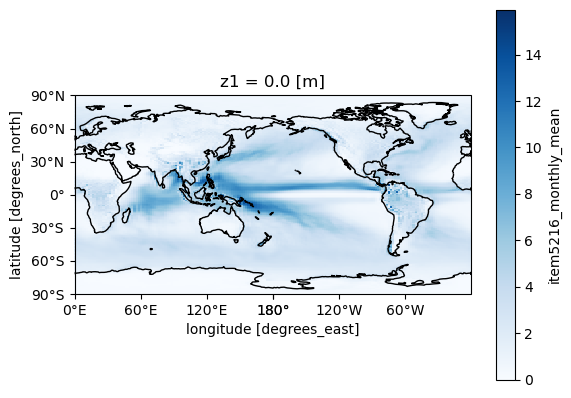

In [40]:
fig, ax = map_with_latlon(central_longitude=180)
(control_precip.mean('time2')*86400).plot(ax=ax, cmap='Blues', transform=ccrs.PlateCarree())
ax.coastlines(lw=1)

Nice! Trust me on this, the model is doing a pretty decent job here at representing the basic features of precipitation. 

For example, the long band of precipitation across the Pacific (at ≈10deg North) is called the Inter-tropical Convergence Zone, or "ITCZ". 

Again, we mostly see that the really high values of precipitation are collocated with high-values of SST! But it's not always this simple.

# Now, for our next trick...

As I mentioned before, and as you read in the Baker et al (2019) paper, they didn't just do control simulations! For each initial condition, they also did an *SST perturbation experiment!*

In fact...they did 5,000 of them! 


You'll be happy to know I've done a lot of the pre-processing already, so lets just take a quick look at the data.

In [8]:
delta_SST = xr.open_dataarray("dSST_pr.nc")
delta_precip = xr.open_dataarray("delta_pr.nc")

I've used an `idx` from `0-->4999` to denote the 5,000 different perturbation experiments, and you can just scan through to get a sense for what they look like.

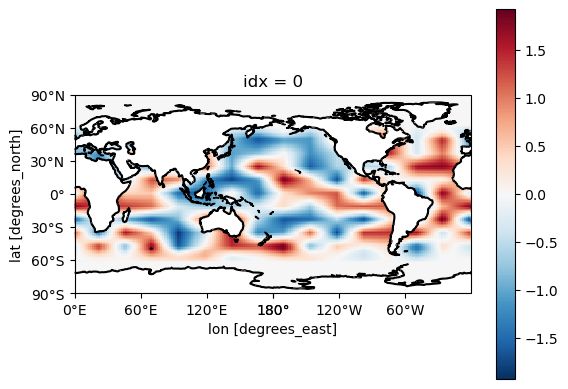

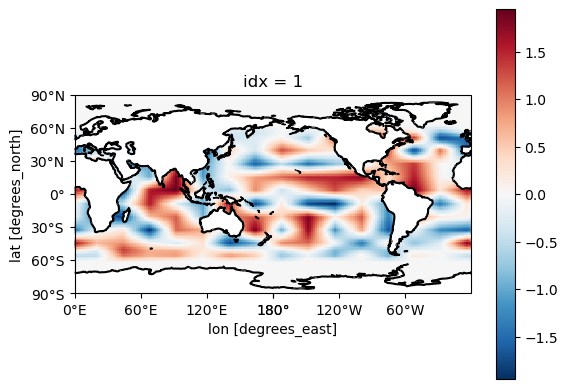

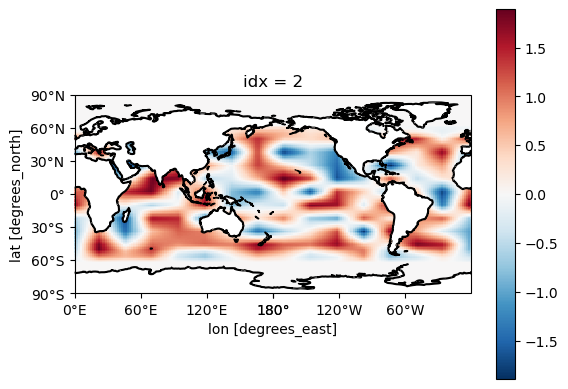

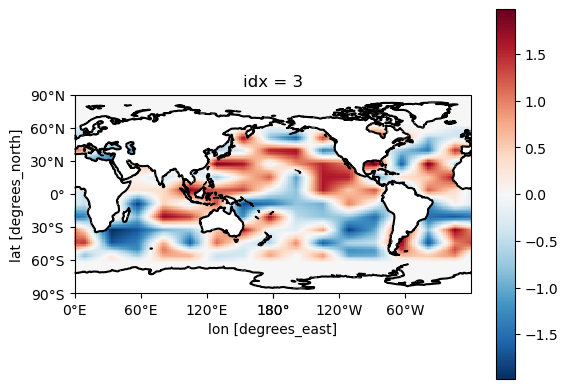

In [30]:
for idx in (0, 1, 2, 3):
    fig, ax = map_with_latlon(central_longitude=180)
    delta_SST.sel(idx=idx).where(landmask).plot(transform=ccrs.PlateCarree())
    ax.coastlines()
# Question: are the temperature perturbations over land just ignored?

## Q: do the 5,000 `delta_SST` maps uniformly the space between ±60 deg?

To answer this, we can quickly plot the average SST perturbation across all 5,000 of the runs. As you can see, there is a *tiny* bias towards certain regions, but the magnitudes are ~0.01K, so we can safely say we're not biased towards over-/under-sampling any particular regions.

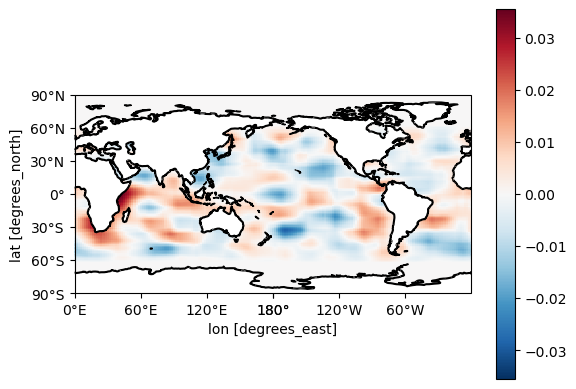

In [32]:
fig, ax = map_with_latlon(central_longitude=180)
delta_SST.mean('idx').where(landmask).plot(transform=ccrs.PlateCarree())
ax.coastlines()

Now, for each `idx` of `delta_SST`, we also have a corresponding map of the change in `precipitation` in that experiment! To make the data volumes more manageable, I've provided the `precipitation` changes as either:
 - a time-average over the whole simulation (`time_avg='ANNUAL'`)
 - or averages over specific seasons (December,January,February: 'DJF' // March,April,May: 'MAM' // June,July,August: 'JJA' // Sept,Oct,Nov: 'SON')
 
Also note that I've already multiplied these changes by 86400 to get units of mm/day

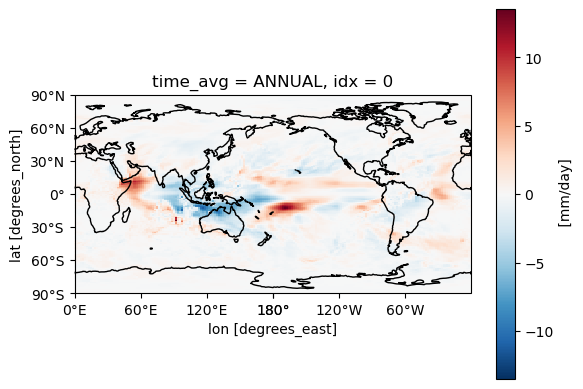

In [36]:
fig, ax = map_with_latlon(central_longitude=180)
delta_precip.sel(idx=0, time_avg='ANNUAL').plot(transform=ccrs.PlateCarree())
ax.coastlines()

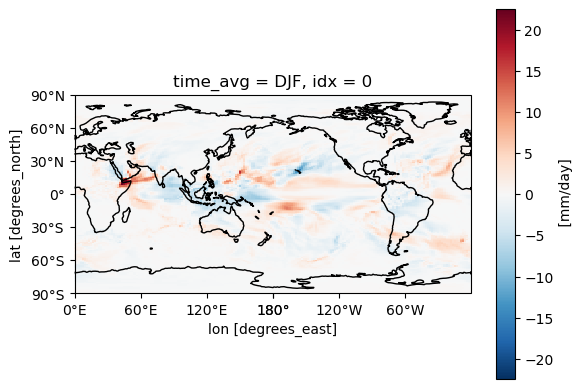

In [38]:
fig, ax = map_with_latlon(central_longitude=180)
delta_precip.sel(idx=0, time_avg='DJF').plot(transform=ccrs.PlateCarree())
ax.coastlines()

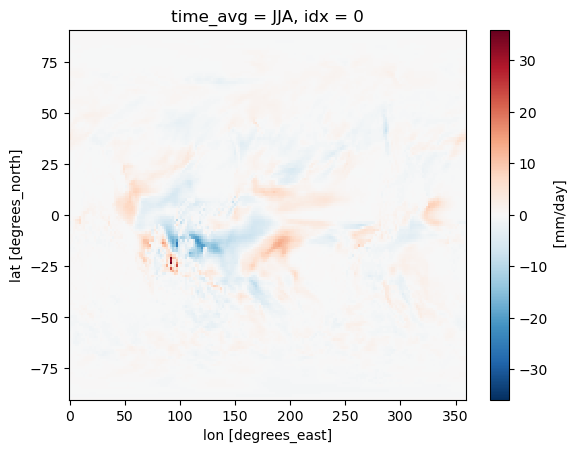

In [20]:
delta_precip.sel(idx=0, time_avg='JJA').plot()

#### As you can see ^^^,  even for a single SST perturbation, the precipitation changes depend a lot on the season considered. We can chat about this in person sometime if you want

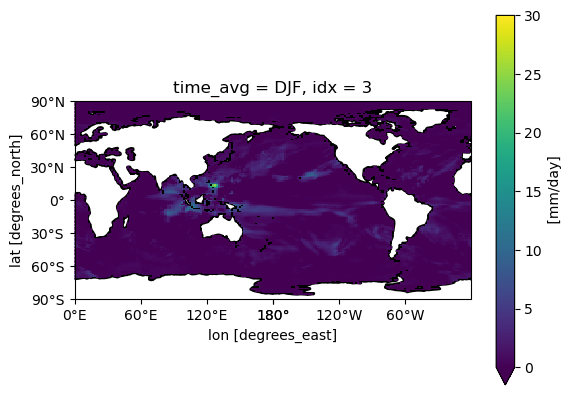

In [21]:
fig, ax = map_with_latlon(lw_=2, central_longitude=180)
delta_precip.sel(idx=3, time_avg='DJF').where(landmask).plot(ax=ax,  vmin=0, vmax=30, 
                                           transform=ccrs.PlateCarree())

# pick a point on the grid and do a linear regression of the areas which are most sensitive to it


# So yeah, have some fun playing around with the data for now! If you get stuck just message me on Slack or show up to AOPP room 107 to ask in person :) 


## Goal: plot a graph of the GTO given a particular grid point of precipitation, time averaged across the year

In [1]:
# Select a point of delta precipitation data (vector of 5000 entries)

mylat = 45
mylon = 0

delta_precip_vector = delta_precip.sel(time_avg='ANNUAL', 
                 lat=mylat, 
                 lon=mylon).values

delta_precip_vector

NameError: name 'delta_precip' is not defined

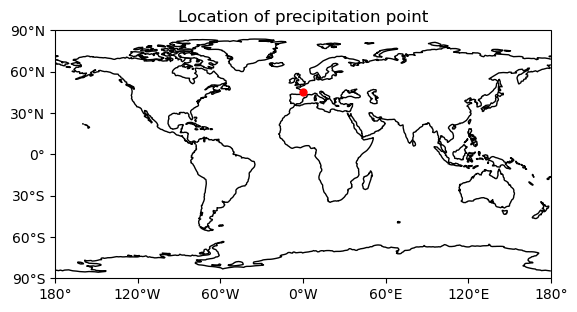

In [10]:
# Visualise this point on the world map

fig, ax = map_with_latlon(lw_=1, central_longitude=0)
plt.plot(mylon, mylat,  markersize=5, marker='o', color='red')
plt.title('Location of precipitation point')
plt.show()

As per Baker et al. (2019) and Li et al. (2012), the smoothed GTO estimate at a gridpoint $\mathbf{x}_i$ may be calculated using

$$ G(\mathbf{x}_i) = \frac {\text{Cov}[\Delta \text{SST}_n(\mathbf{x}_i), \mathbf{R}_n]}{\frac{T^2_\text{max}}{3}L_x L_y} + e $$

where $\Delta \text{SST}_n(\mathbf{x}_i)$ is a vector of the 5000 time-independent SST perturbation anomalies at the gridpoint $\mathbf{x}_i$, $\mathbf{R}_n$ a vector of the 5000 atmospheric anomaly indices (in this case the delta_precip vector at the chosen precipitation location), $T_\text{max} = 2\text{K}$ the maximum temperature perturbation, and $L_x = a \lambda_0 \cos{\phi_i}$ and $L_y = a \phi_0$ are the local length scales of the lattice. Here $a$ is the mean earth radius, $\phi_0$ and $\lambda_0$ are the latitude and longitude spacings in radians, and $\phi_i$ the latitude of the grid point in question.

In [13]:
T_max = 2 # maximum temperature perturbation
a = 6371000 # earth radius in meters
phi_0 = math.radians(1.25) # latitude spacing in radians
lambda_0 = math.radians(1.875) # longitude spacing in radians

In [25]:
delta_SST.sel(lat=mylat, lon=mylon).values

array([-0.909841  , -1.24014378,  0.29144725, ..., -0.31794032,
       -0.2309393 , -0.75084734])

In [31]:
'''
Compute the GTO at each grid point
'''
lats = delta_SST.lat.values
lons = delta_SST.lon.values

G = xr.DataArray(np.zeros((len(lats),len(lons))), coords=[lats, lons], dims=["latitude", "longitude"])
G # temporary datarray to store value of GTO

<xarray.DataArray (latitude: 145, longitude: 192)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * latitude   (latitude) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * longitude  (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1

In [36]:
L_y = a*phi_0
for lat in lats[::10]:
    L_x = a*lambda_0*math.cos(math.radians(lat))
    for lon in lons[::10]:
        G.loc[lat, lon] = np.cov(delta_SST.sel(lat=lat, lon=lon).values, delta_precip_vector)[0][1] / ((1/3)*T_max**2 * L_x * L_y)
    print('latitude {} completed'.format(lat))

latitude -90.0 completed
latitude -88.75 completed
latitude -87.5 completed
latitude -86.25 completed
latitude -85.0 completed
latitude -83.75 completed
latitude -82.5 completed
latitude -81.25 completed
latitude -80.0 completed
latitude -78.75 completed
latitude -77.5 completed
latitude -76.25 completed
latitude -75.0 completed
latitude -73.75 completed
latitude -72.5 completed
latitude -71.25 completed
latitude -70.0 completed
latitude -68.75 completed
latitude -67.5 completed
latitude -66.25 completed
latitude -65.0 completed


KeyboardInterrupt: 

In [ ]:
G